In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, \
    Lambda, UpSampling2D, Cropping2D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import regularizers
import tensorflow as tf

2024-03-15 12:00:53.756935: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 12:00:53.757030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 12:00:53.912918: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
os.environ["PYTHONHASHSEED"]=str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
batch_size=8
lr=1e-4
epoch=100
height=128
width=128

In [6]:
# Function to load and preprocess the images and corresponding masks from folders
def load_images_and_masks_from_folder(images_folder, optic_cup_folder):
    images = []
    masks_optic_cup = []
    for filename in os.listdir(images_folder):
        img_path = os.path.join(images_folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))  # Resize images to match the U-Net input size
            images.append(img)
            mask_cup_path = os.path.join(optic_cup_folder, filename.split('.')[0] + '_cupsegSoftmap.png')
            mask_cup = cv2.imread(mask_cup_path, cv2.IMREAD_GRAYSCALE)
            if mask_cup is not None:
                mask_cup = cv2.resize(mask_cup, (128, 128))
                masks_optic_cup.append(mask_cup.reshape((128, 128, 1)))
    return np.array(images), np.array(masks_optic_cup)

# Example usage
train_images_folder = '/kaggle/input/glaucomaupdated/Drishti-GS1_files/Training/Images'
train_masks_folder = '/kaggle/input/glaucomaupdated/Drishti-GS1_files/Training/optic_cup'

train_images,train_masks_oc = load_images_and_masks_from_folder(train_images_folder,train_masks_folder)

# Load validation images and masks
val_images_folder = '/kaggle/input/glaucomaupdated/Drishti-GS1_files/Test/Images'
val_masks_folder = '/kaggle/input/glaucomaupdated/Drishti-GS1_files/Test/optic_cup'

val_images, val_masks_optic_cup = load_images_and_masks_from_folder(val_images_folder, val_masks_folder)

print("Shape of train_images:", train_images.shape)
print("Shape of train_masks_optic_cup:", train_masks_oc.shape)
print("Shape of val_images:", val_images.shape)
print("Shape of val_masks_optic_cup:", val_masks_optic_cup.shape)

Shape of train_images: (50, 128, 128, 3)
Shape of train_masks_optic_cup: (50, 128, 128, 1)
Shape of val_images: (51, 128, 128, 3)
Shape of val_masks_optic_cup: (51, 128, 128, 1)


In [5]:
# def tf_parse(x,y):
#     def _parse(x,y):
#         x=load_image(x)
#         y=load_mask(y)
#         return x,y
    
#     x,y= tf.numpy_function(_parse,[x,y],[tf.float64,tf.float64])
#     x.set_shape([height,width,3])
#     y.set_shape([height,width,1])
    
#     return x,y

In [7]:
def tf_dataset(x,y,batch=8):
    dataset=tf.data.Dataset.from_tensor_slices((x,y))
#     dataset=dataset.map(tf_parse,num_parallel_calls=tf.data.AUTOTUNE)
    dataset=dataset.batch(batch)
    dataset=dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [8]:
train_dataset=tf_dataset(train_images,train_masks_oc, batch=batch_size)
valid_dataset=tf_dataset(val_images,val_masks_optic_cup, batch=batch_size)

In [9]:
for x,y in valid_dataset:
    print(x.shape,y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)
(8, 128, 128, 3) (8, 128, 128, 1)
(8, 128, 128, 3) (8, 128, 128, 1)
(8, 128, 128, 3) (8, 128, 128, 1)
(8, 128, 128, 3) (8, 128, 128, 1)
(8, 128, 128, 3) (8, 128, 128, 1)
(3, 128, 128, 3) (3, 128, 128, 1)


In [10]:
def conv_block(inputs, num_filters):
    x=Conv2D(num_filters,3,padding="same")(inputs)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    x=Conv2D(num_filters,3,padding="same")(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    return x

In [11]:
def encoder_block(inputs,num_filters):
    x=conv_block(inputs,num_filters)
    p=MaxPool2D((2,2))(x)
    return x,p

In [12]:
def decoder_block(inputs,skip,num_filters):
    x=Conv2DTranspose(num_filters,(2,2),strides=2,padding="same")(inputs)
    x=Concatenate()([x,skip])
    x=conv_block(x,num_filters)
    return x

In [13]:
def build_unet(input_shape):
    inputs=Input(input_shape)
    """Encoder"""
    s1,p1=encoder_block(inputs,64)
    s2,p2=encoder_block(p1,128)
    """Bridge"""
    b1=conv_block(p2,256)
    """Decoder"""
    d1=decoder_block(b1,s2,128)
    d2=decoder_block(d1,s1,64)
    
    outputs=Conv2D(1,1,padding="same",activation="sigmoid")(d2)
    
    model=Model(inputs,outputs,name="UNET")
    return model

In [14]:
from tensorflow.keras.layers import MaxPool2D, Conv2DTranspose, Concatenate
input_shape=(height,width,3)
model=build_unet(input_shape)

In [15]:
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 1,867,969 (7.13 MB)

 Trainable params: 1,865,409 (7.12 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [16]:
opt=tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["acc"])

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [18]:
history= model.fit(
train_dataset,
validation_data=valid_dataset,
epochs=epoch,
callbacks=callback
)

Epoch 1/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 3:00 30s/step - acc: 0.1436 - loss: -9.6752

I0000 00:00:1710504669.226833      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - acc: 0.2584 - loss: -21.1656 - val_acc: 7.5875e-04 - val_loss: -75.6097
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - acc: 0.6116 - loss: -56.0989 - val_acc: 0.0014 - val_loss: -119.3229
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - acc: 0.6865 - loss: -85.0497 - val_acc: 0.0389 - val_loss: -139.7868
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - acc: 0.7232 - loss: -116.1443 - val_acc: 0.0841 - val_loss: -131.9009
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - acc: 0.7751 - loss: -144.0352 - val_acc: 0.1024 - val_loss: -176.5945
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - acc: 0.8478 - loss: -159.1650 - val_acc: 0.1273 - val_loss: -135.7090
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - acc: 0.9037 - loss: -170.0865 - val_acc: 0.1503 - val_loss: -130.5575
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - acc: 0.9244 - loss: -177.2076 - val_acc: 0.1751 - val_loss: -147.6116
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


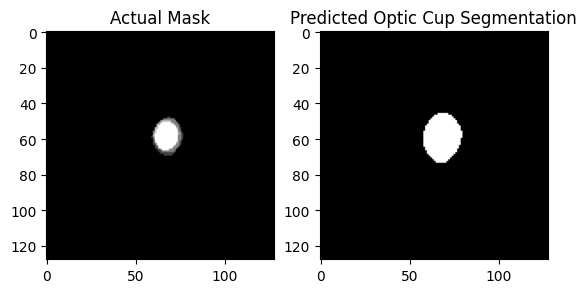

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


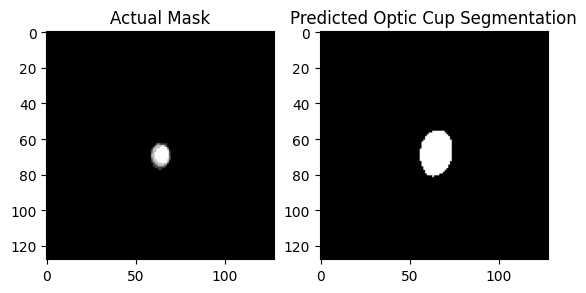

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


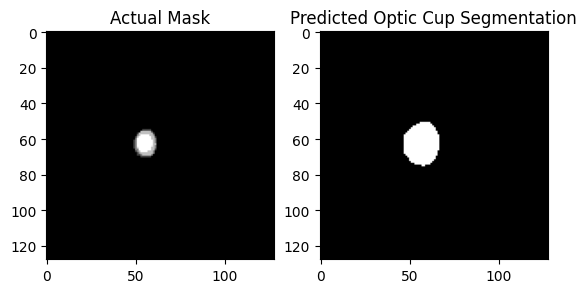

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


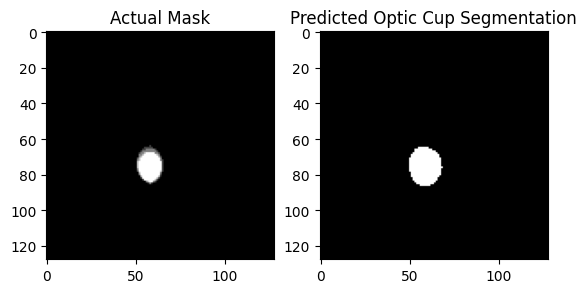

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


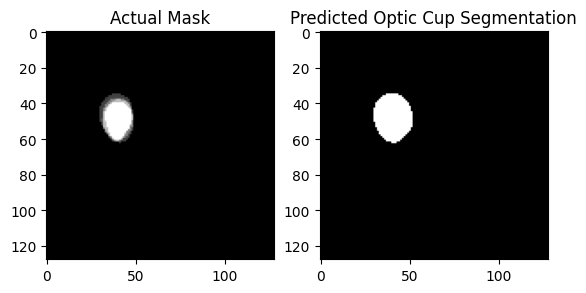

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


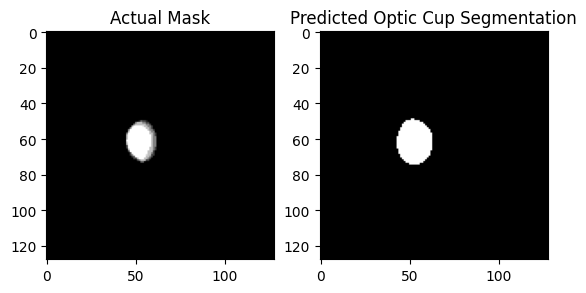

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


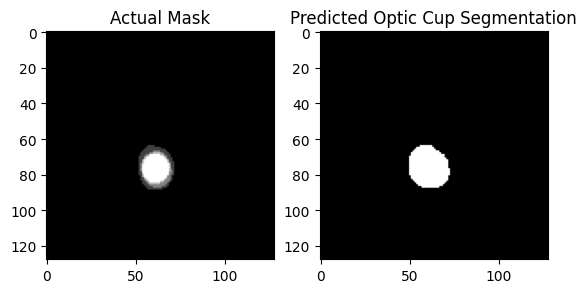

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


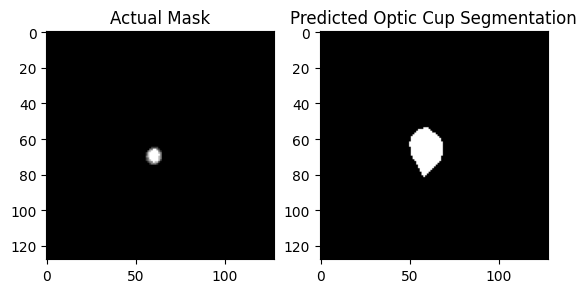

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


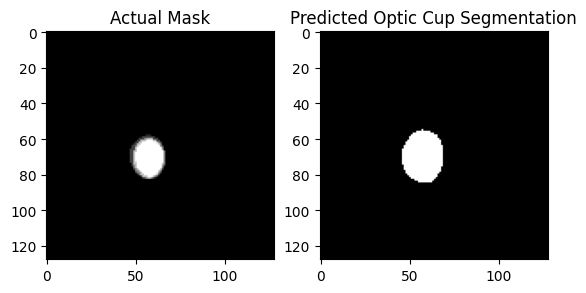

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


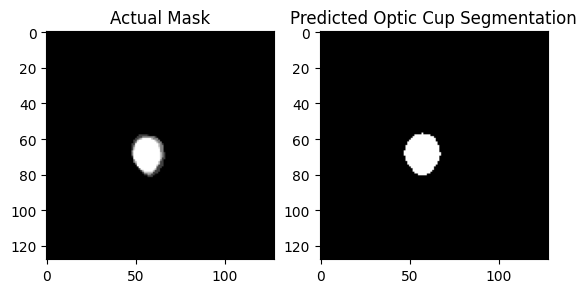

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


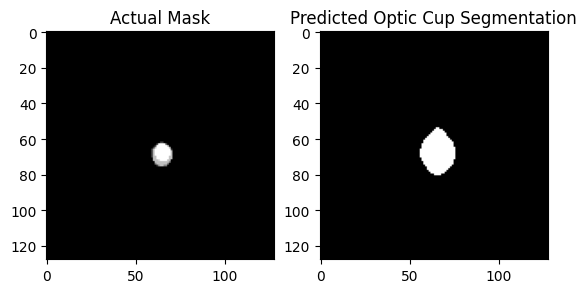

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


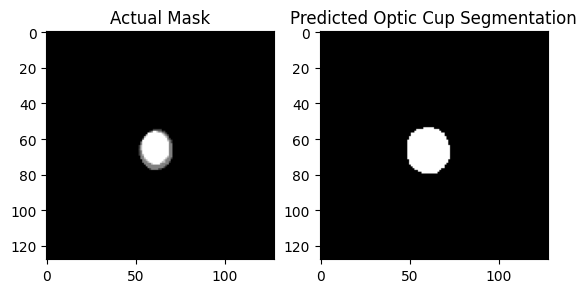

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


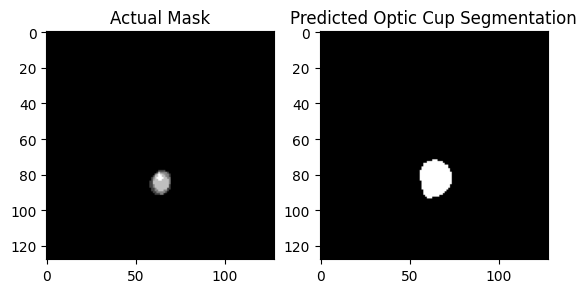

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


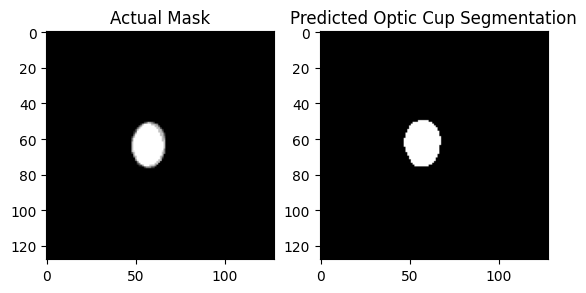

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


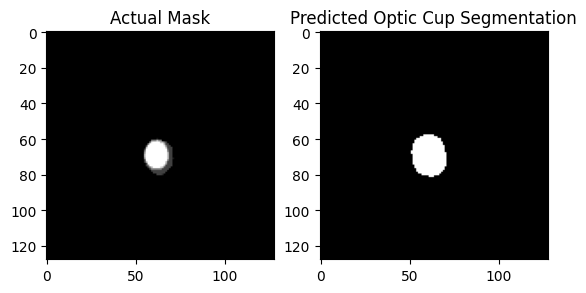

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


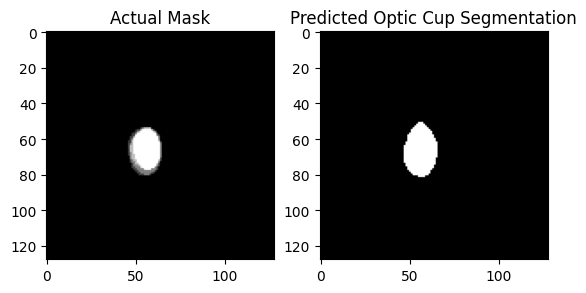

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


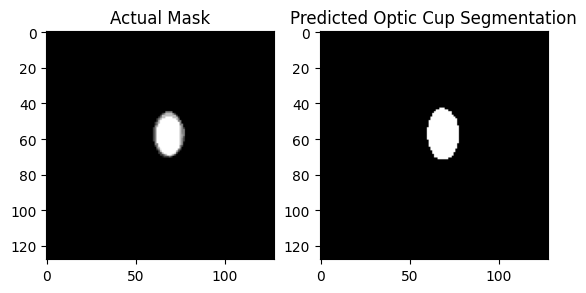

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


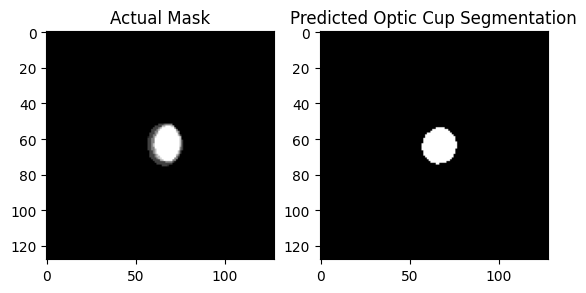

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


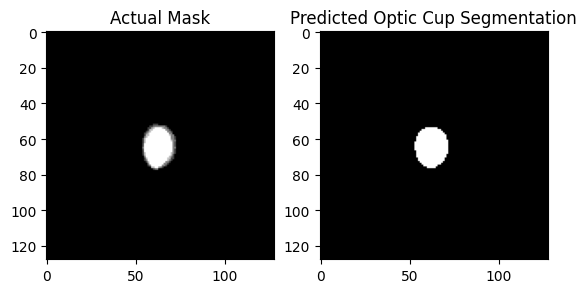

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


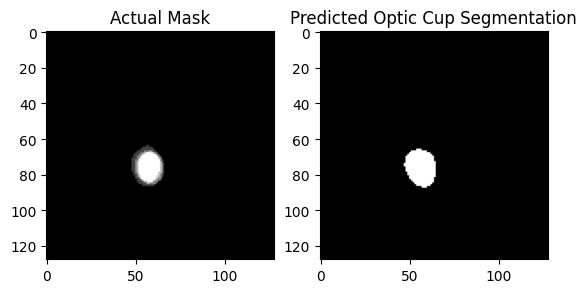

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


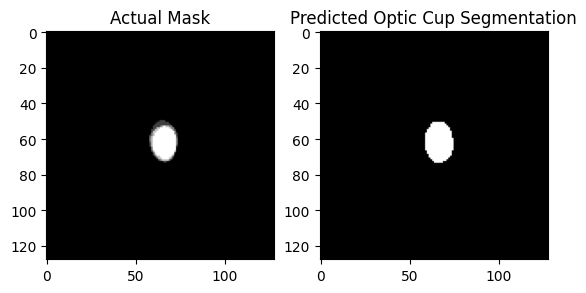

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


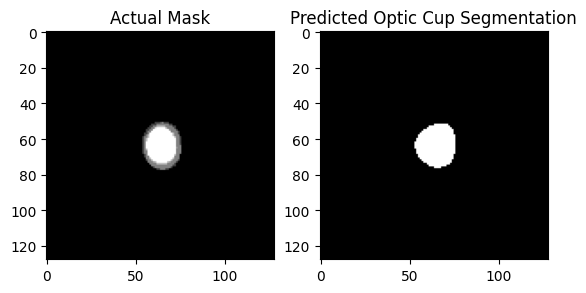

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


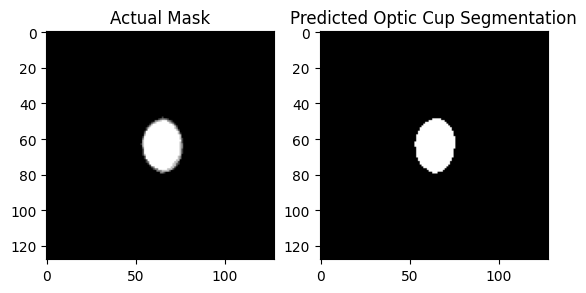

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


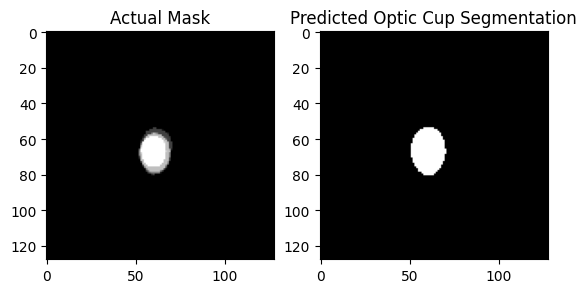

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


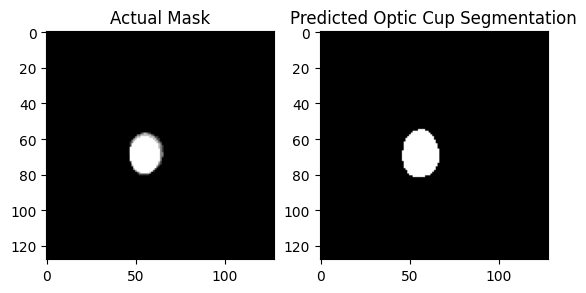

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


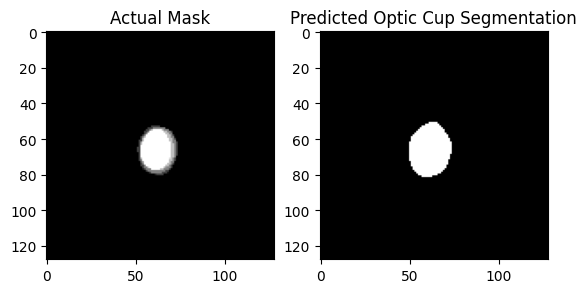

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


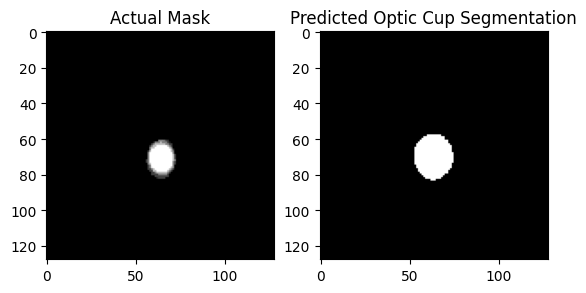

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


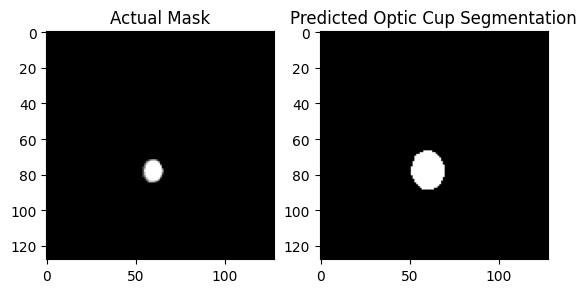

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


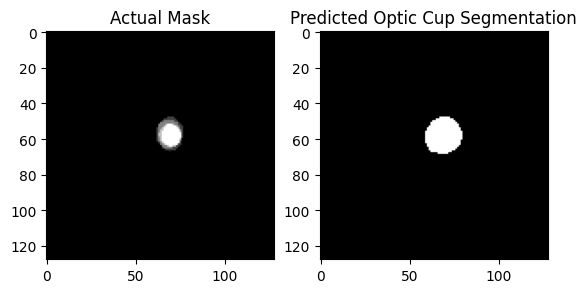

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


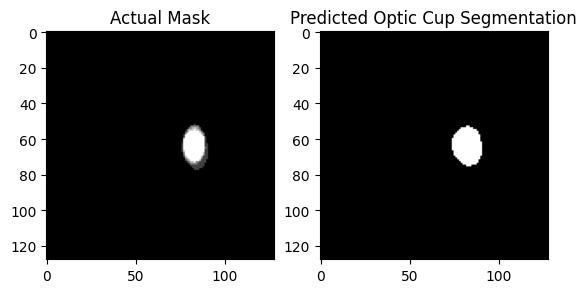

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


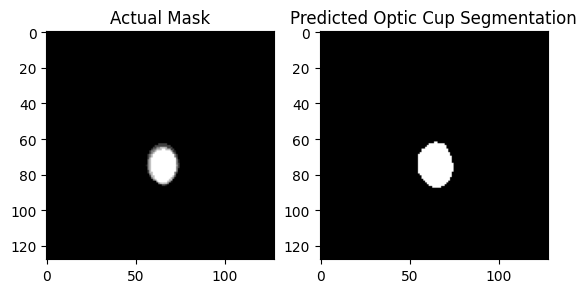

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


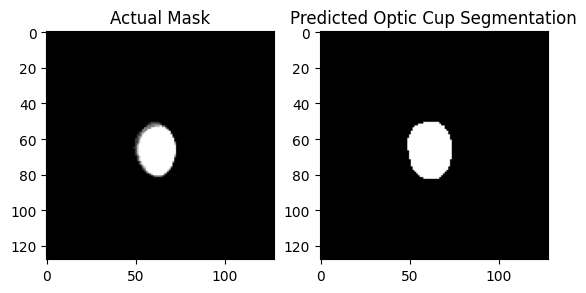

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


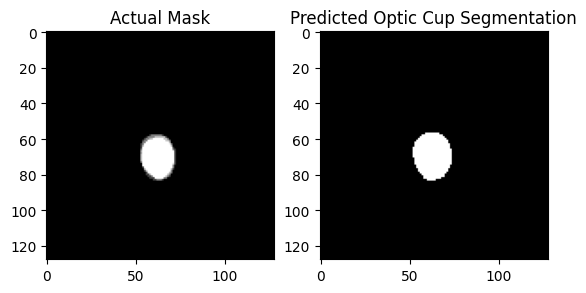

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


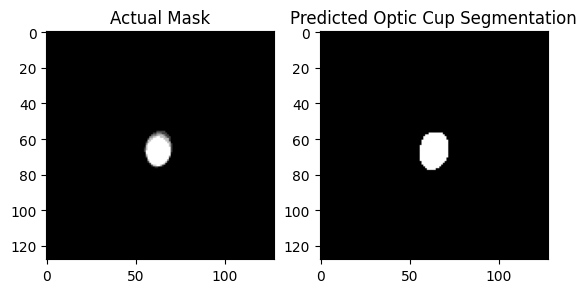

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


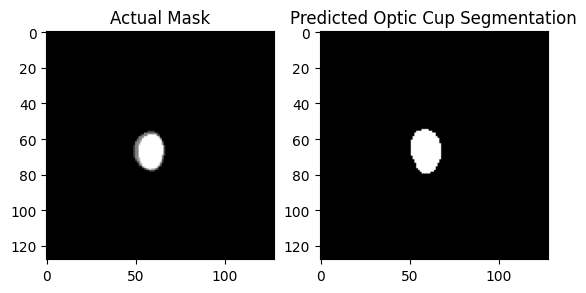

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


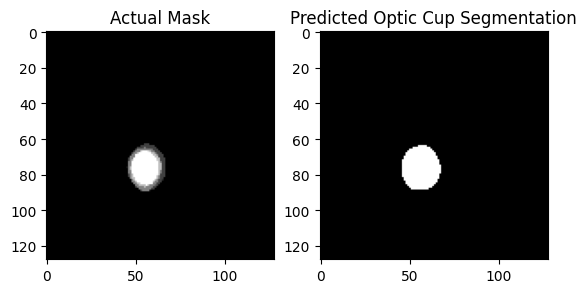

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


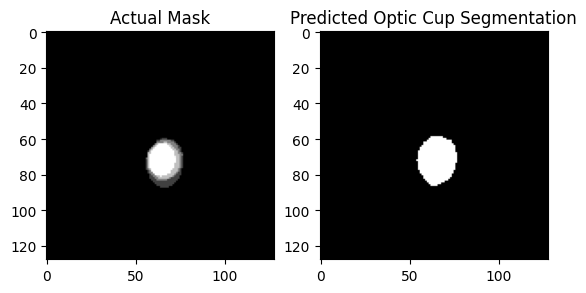

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


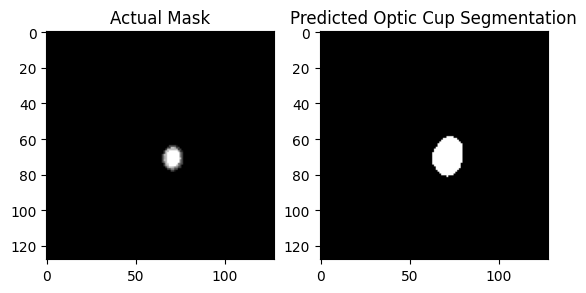

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


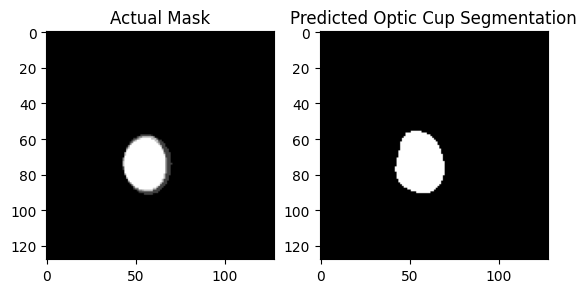

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


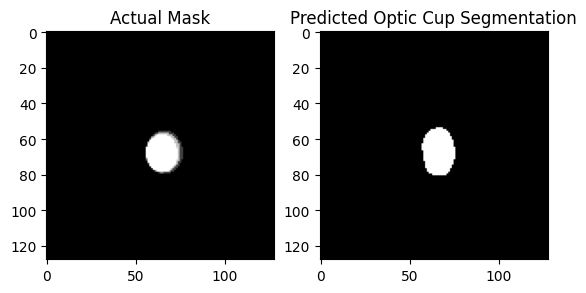

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


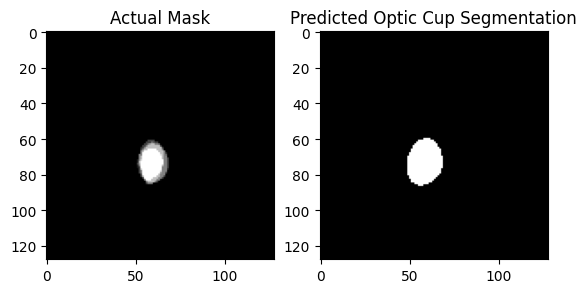

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


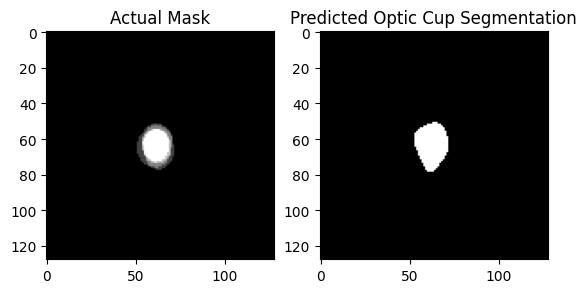

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


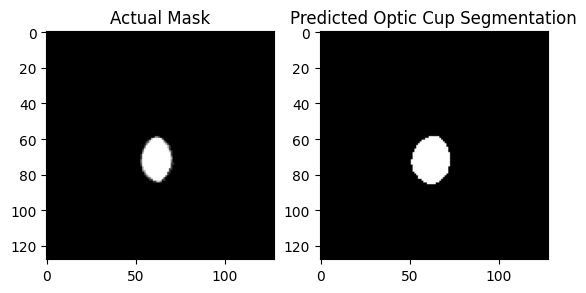

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


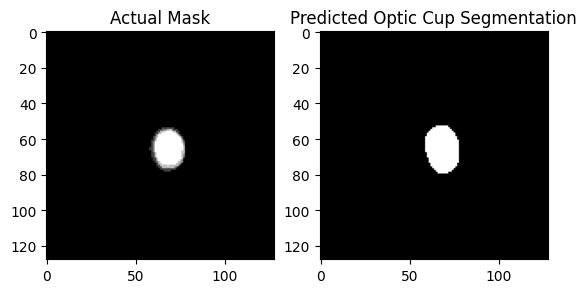

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


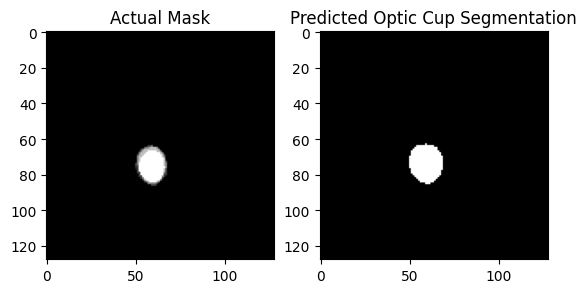

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


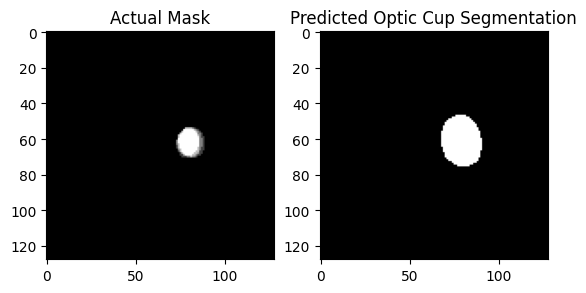

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


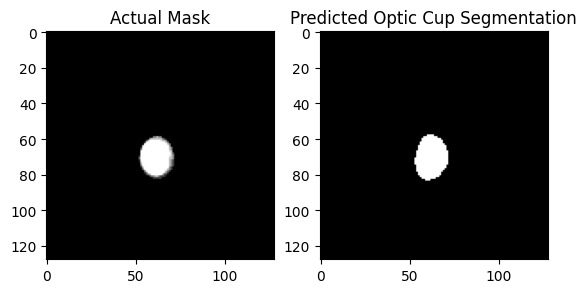

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


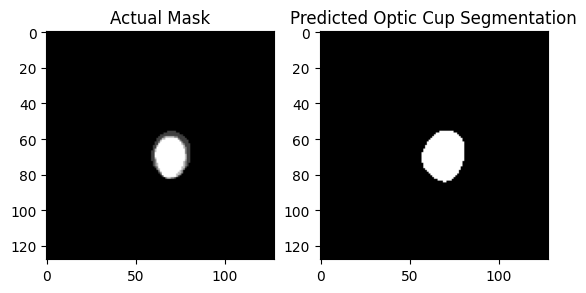

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


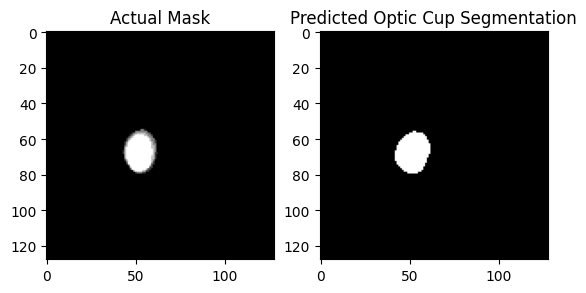

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


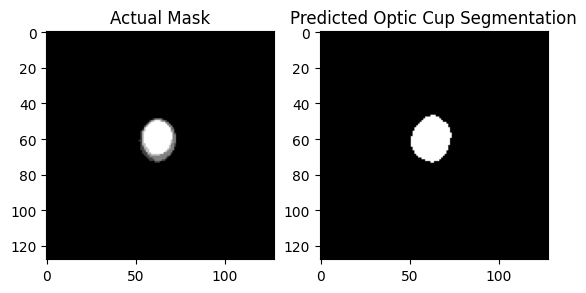

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


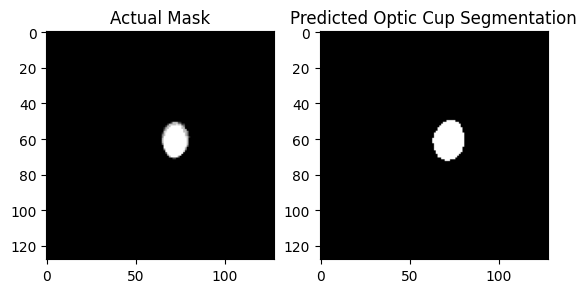

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_mask(model, image):
    # Preprocess the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))  # Resize image to match the U-Net input size
    image = np.expand_dims(image, axis=0)  # Add an extra dimension for the batch size

    # Use the model to predict the mask
    predicted_mask = model.predict(image)[0, :, :, 0]

    # Binarize the predicted mask
    binarized_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Find contours in the binarized mask
    contours, _ = cv2.findContours(binarized_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour is the optic cup
    optic_cup_contour = max(contours, key=cv2.contourArea)

    # Draw the optic cup contour on a black mask
    cup_mask = np.zeros_like(binarized_mask)
    cv2.drawContours(cup_mask, [optic_cup_contour], -1, 1, thickness=cv2.FILLED)
    return cup_mask

def display_mask(predict, actual):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title('Actual Mask')
    plt.imshow(actual, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Predicted Optic Cup Segmentation')
    plt.imshow(predict, cmap='gray')

    plt.show()

# Example usage
model = model  # Your trained U-Net model
test_images_folder = '/kaggle/input/glaucomaupdated/Drishti-GS1_files/Test/Images'  # Path to test images folder
output_masks_folder = '/kaggle/working/predicted_masks_cup'  # Output folder to save predicted masks

# Create output masks folder if it doesn't exist
if not os.path.exists(output_masks_folder):
    os.makedirs(output_masks_folder)

# Loop through all test images
for filename in os.listdir(test_images_folder):
    image_path = os.path.join(test_images_folder, filename)
    actual_mask_path = os.path.join('/kaggle/input/glaucomaupdated/Drishti-GS1_files/Test/optic_cup', filename.split('.')[0] + '_cupsegSoftmap.png')

    # Load the test image and actual mask
    image = cv2.imread(image_path)
    actual_mask = cv2.imread(actual_mask_path, cv2.IMREAD_GRAYSCALE)
    actual_mask = cv2.resize(actual_mask, (128, 128))  # Resize mask to match the U-Net input size

    # Predict the mask
    predicted_mask = predict_mask(model, image)

    # Display the predicted mask along with the actual mask
    display_mask(predicted_mask, actual_mask)

    # Save the predicted mask
    output_mask_path = os.path.join(output_masks_folder, filename.split('.')[0] + '_predicted_mask.png')
    cv2.imwrite(output_mask_path, predicted_mask * 255)


In [22]:
# Function to load and preprocess the images and corresponding masks from folders
def load_images_and_diskmasks_from_folder(images_folder, optic_disk_folder):
    images = []
    masks_optic_disk = []
    for filename in os.listdir(images_folder):
        img_path = os.path.join(images_folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))  # Resize images to match the U-Net input size
            images.append(img)
            mask_disk_path = os.path.join(optic_disk_folder, filename.split('.')[0] + '_ODsegSoftmap.png')
            mask_disk = cv2.imread(mask_disk_path, cv2.IMREAD_GRAYSCALE)
            if mask_disk is not None:
                mask_disk = cv2.resize(mask_disk, (128, 128))
                masks_optic_disk.append(mask_disk.reshape((128, 128, 1)))
    return np.array(images), np.array(masks_optic_disk)

# Example usage
train_images_fol = '/kaggle/input/glaucomaupdated/Drishti-GS1_files/Training/Images'
train_masks_fol = '/kaggle/input/glaucomaupdated/Drishti-GS1_files/Training/optic_disk'

train_img,train_masks_od = load_images_and_diskmasks_from_folder(train_images_fol,train_masks_fol)

# Load validation images and masks
val_images_fol = '/kaggle/input/glaucomaupdated/Drishti-GS1_files/Test/Images'
val_masks_fol = '/kaggle/input/glaucomaupdated/Drishti-GS1_files/Test/optic_disk'

val_img, val_masks_optic_disk = load_images_and_diskmasks_from_folder(val_images_fol, val_masks_fol)

print("Shape of train_images:", train_img.shape)
print("Shape of train_masks_optic_cup:", train_masks_od.shape)
print("Shape of val_images:", val_img.shape)
print("Shape of val_masks_optic_cup:", val_masks_optic_disk.shape)

Shape of train_images: (50, 128, 128, 3)
Shape of train_masks_optic_cup: (50, 128, 128, 1)
Shape of val_images: (51, 128, 128, 3)
Shape of val_masks_optic_cup: (51, 128, 128, 1)


In [23]:
trained_dataset=tf_dataset(train_img,train_masks_od, batch=batch_size)
validation_dataset=tf_dataset(val_img,val_masks_optic_disk, batch=batch_size)

In [24]:
for x,y in trained_dataset:
    print(x.shape,y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)
(8, 128, 128, 3) (8, 128, 128, 1)
(8, 128, 128, 3) (8, 128, 128, 1)
(8, 128, 128, 3) (8, 128, 128, 1)
(8, 128, 128, 3) (8, 128, 128, 1)
(8, 128, 128, 3) (8, 128, 128, 1)
(2, 128, 128, 3) (2, 128, 128, 1)


In [25]:
def convolution_block(inputs, num_filters):
    x=Conv2D(num_filters,3,padding="same")(inputs)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    x=Conv2D(num_filters,3,padding="same")(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    return x

In [26]:
def encode_block(inputs,num_filters):
    x=convolution_block(inputs,num_filters)
    p=MaxPool2D((2,2))(x)
    return x,p

In [27]:
def decode_block(inputs,skip,num_filters):
    x=Conv2DTranspose(num_filters,(2,2),strides=2,padding="same")(inputs)
    x=Concatenate()([x,skip])
    x=conv_block(x,num_filters)
    return x

In [28]:
def unet(input_shape):
    inputs=Input(input_shape)
    """Encoder"""
    s1,p1=encode_block(inputs,64)
    s2,p2=encode_block(p1,128)
    """Bridge"""
    b1=conv_block(p2,256)
    """Decoder"""
    d1=decode_block(b1,s2,128)
    d2=decode_block(d1,s1,64)
    
    outputs=Conv2D(1,1,padding="same",activation="sigmoid")(d2)
    
    model=Model(inputs,outputs,name="UNET")
    return model

In [29]:
from tensorflow.keras.layers import MaxPool2D, Conv2DTranspose, Concatenate
input_shape=(height,width,3)
model2=unet(input_shape)

In [30]:
opt=tf.keras.optimizers.Adam(lr)
model2.compile(loss="binary_crossentropy",optimizer=opt,metrics=["acc"])

In [31]:
history2= model2.fit(
trained_dataset,
validation_data=validation_dataset,
epochs=epoch,
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - acc: 0.2598 - loss: -18.8402 - val_acc: 0.0020 - val_loss: -64.1608
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - acc: 0.6453 - loss: -66.9993 - val_acc: 0.0435 - val_loss: -139.0949
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - acc: 0.7084 - loss: -105.0553 - val_acc: 0.0669 - val_loss: -208.5076
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - acc: 0.7510 - loss: -139.9762 - val_acc: 0.0910 - val_loss: -244.4959
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - acc: 0.7978 - loss: -172.5357 - val_acc: 0.1124 - val_loss: -270.2847
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - acc: 0.8366 - loss: -192.7266 - val_acc: 0.1324 - val_loss: -316.5847
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - acc: 0.8894 - loss: -210.0494 - val_acc: 0.1571 - val_loss: -377.3596
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - acc: 0.9137 - loss: -222.0201 - val_acc: 0.1940 - val_loss: -355.0045
Epoch 9/100
7/7 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step


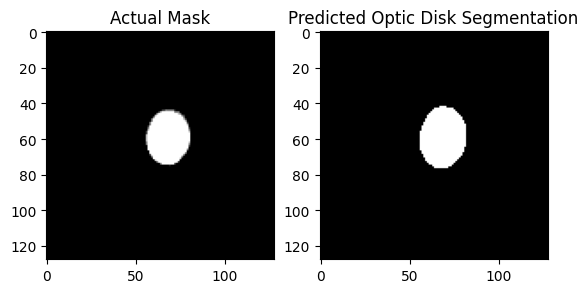

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


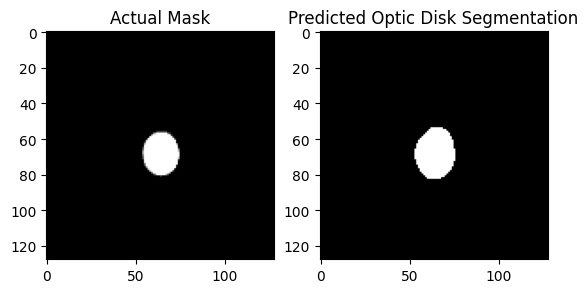

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


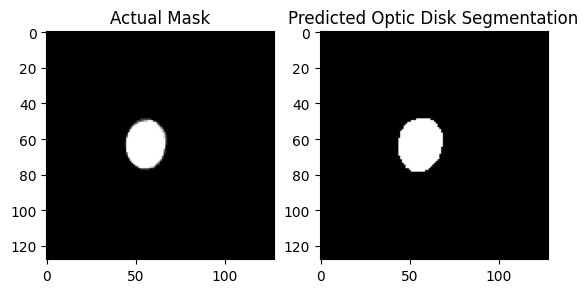

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


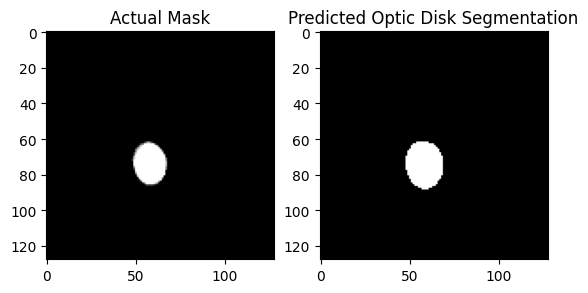

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


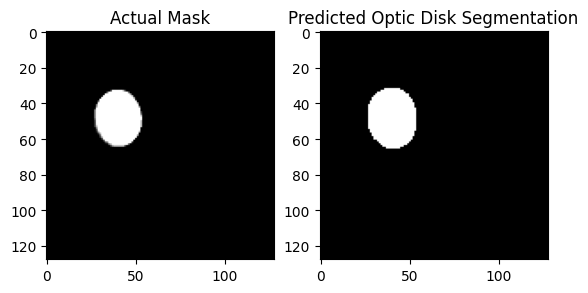

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


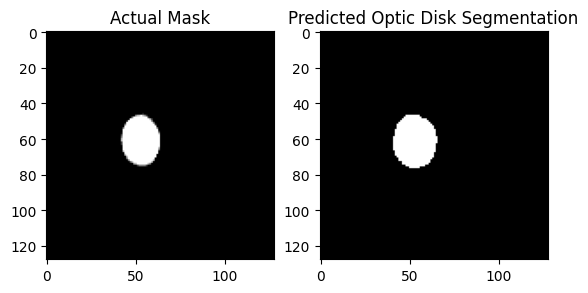

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


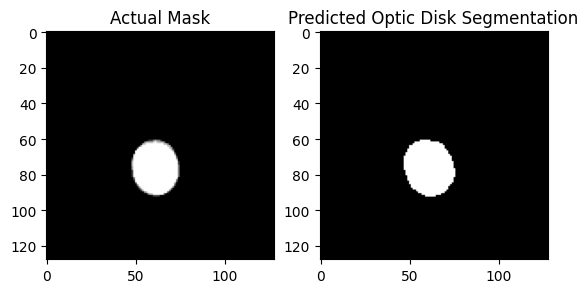

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


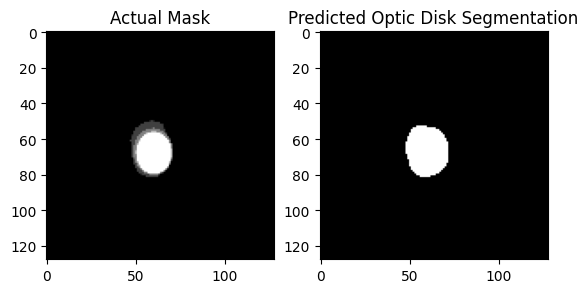

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


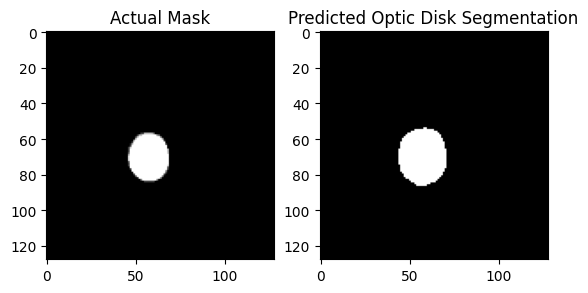

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


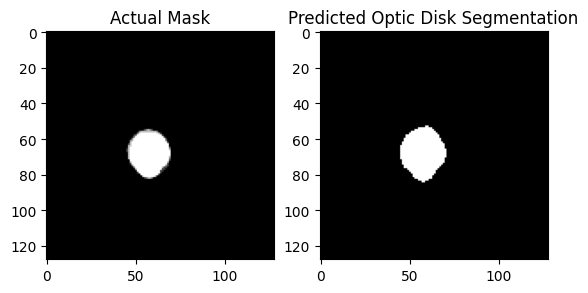

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


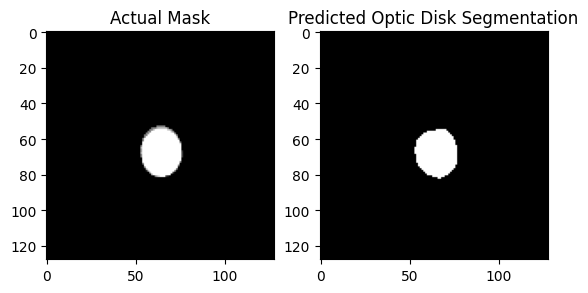

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


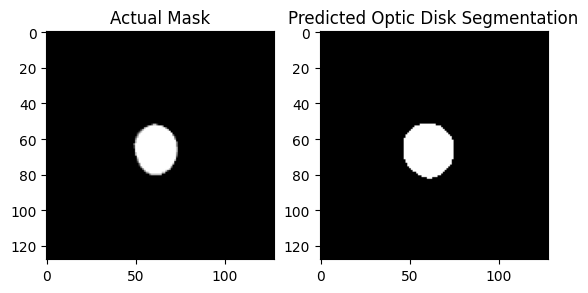

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


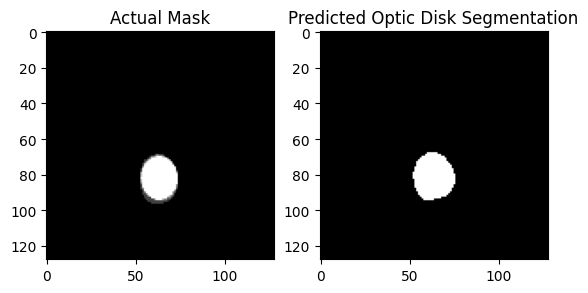

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


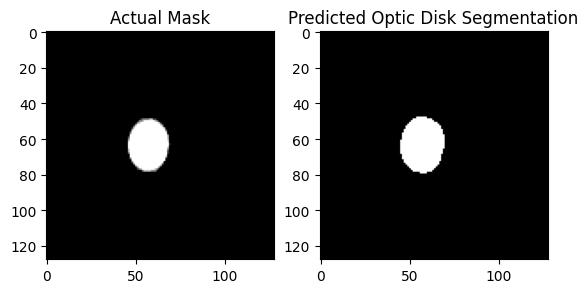

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


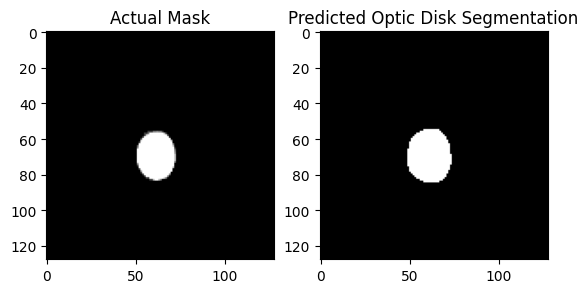

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


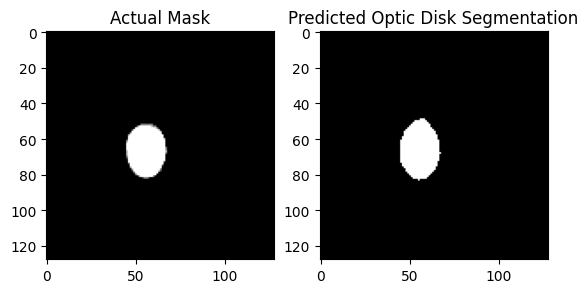

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


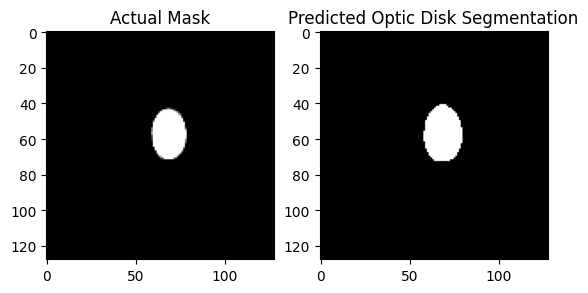

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


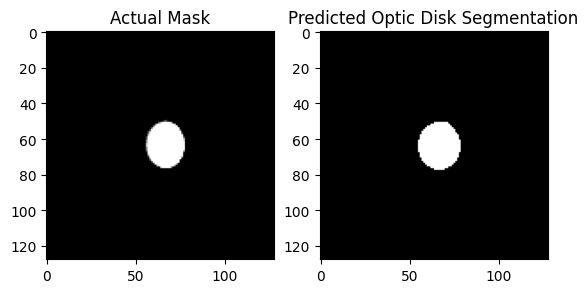

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


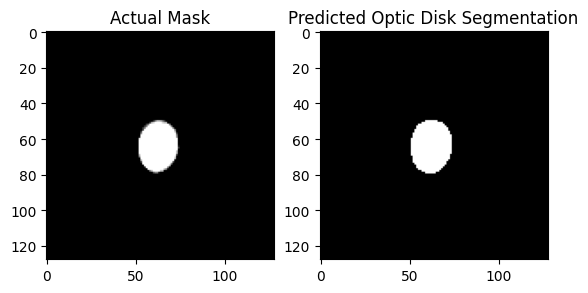

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


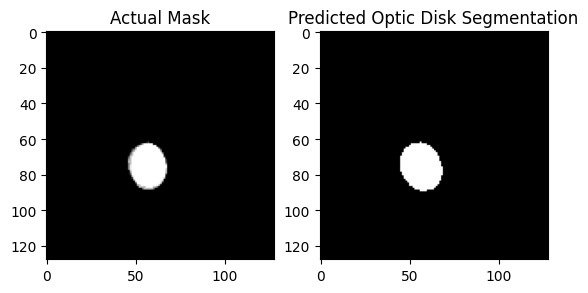

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


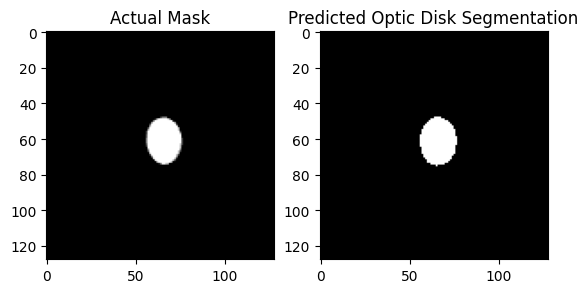

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


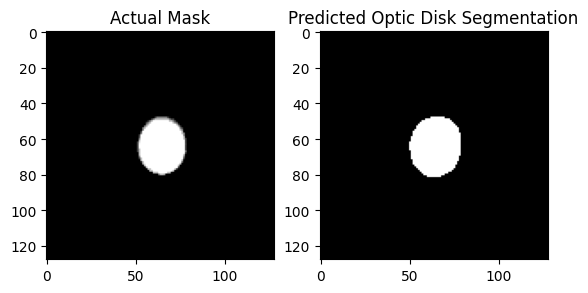

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


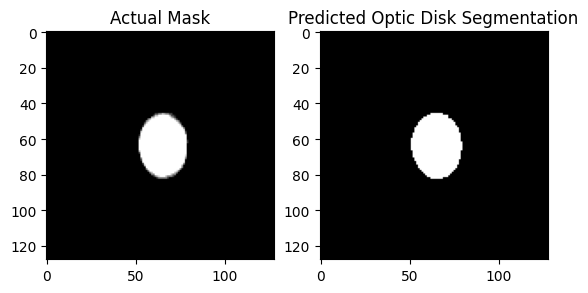

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


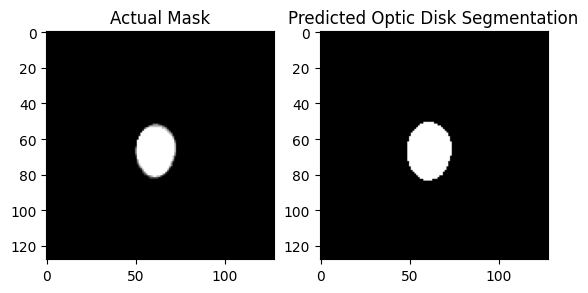

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


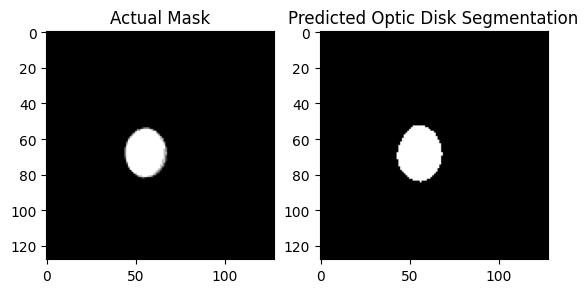

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


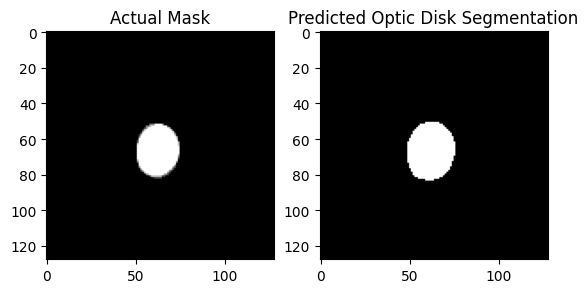

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


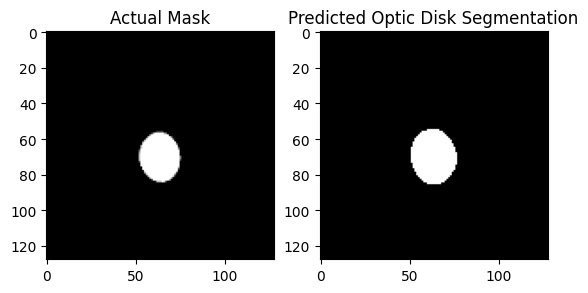

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


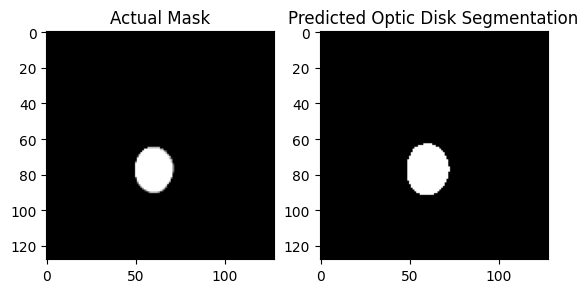

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


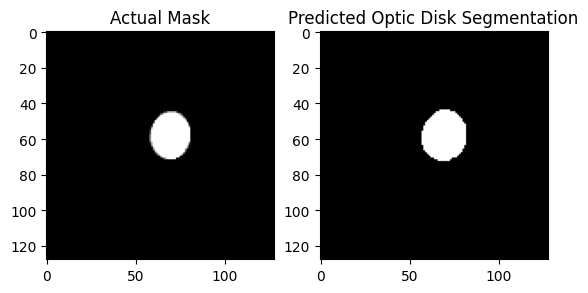

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


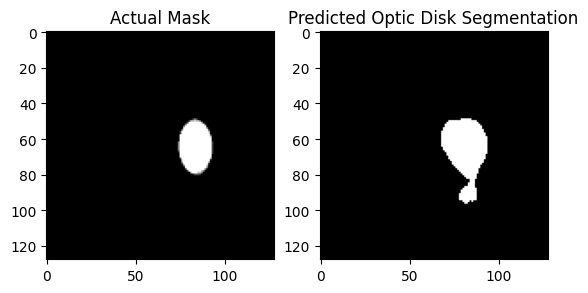

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


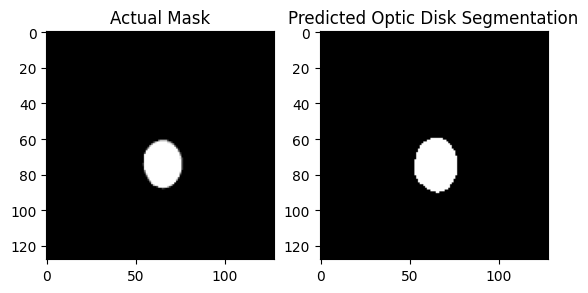

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


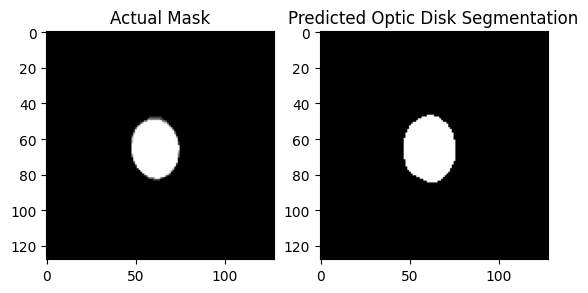

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


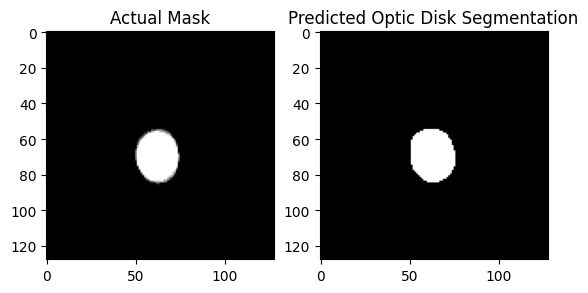

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


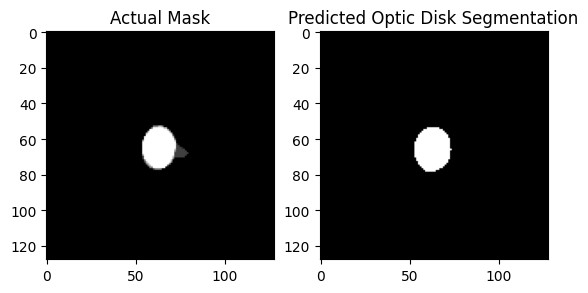

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


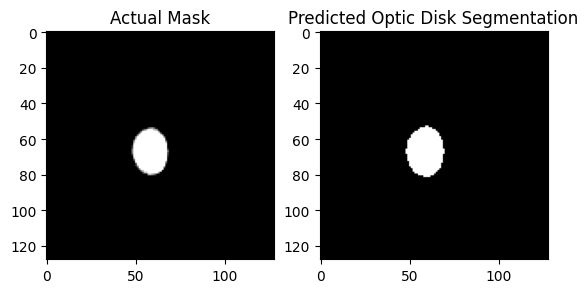

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


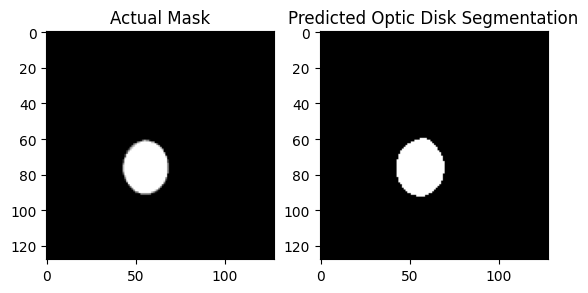

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


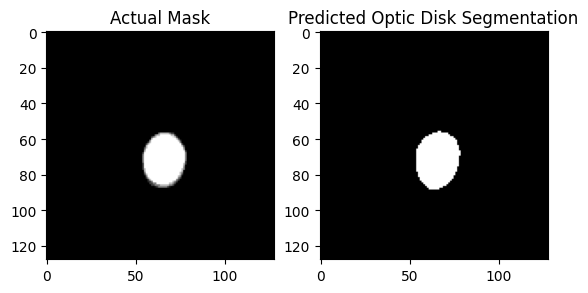

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


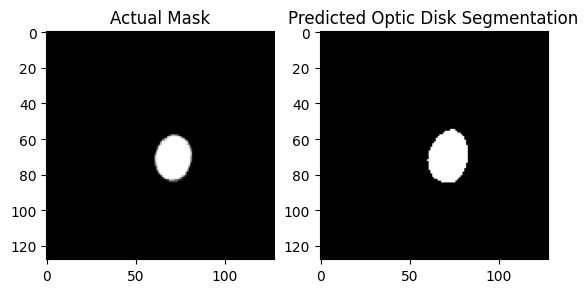

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


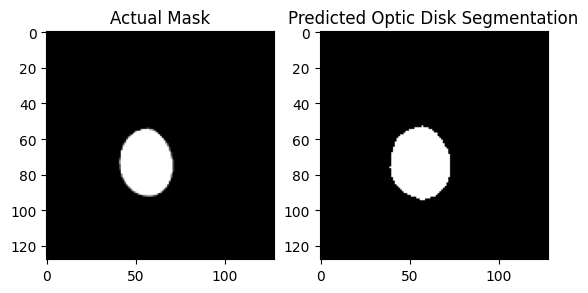

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


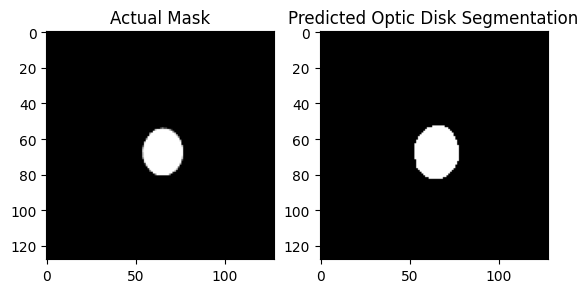

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


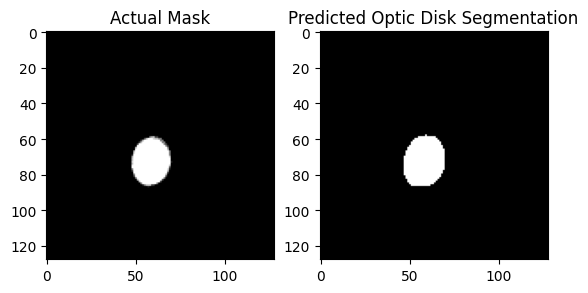

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


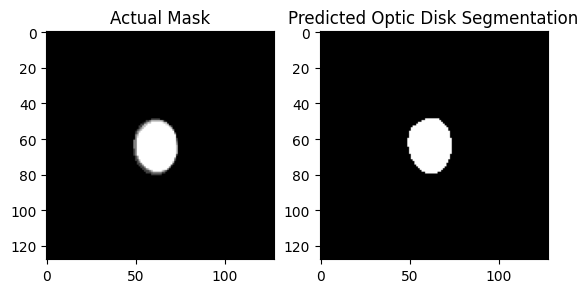

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


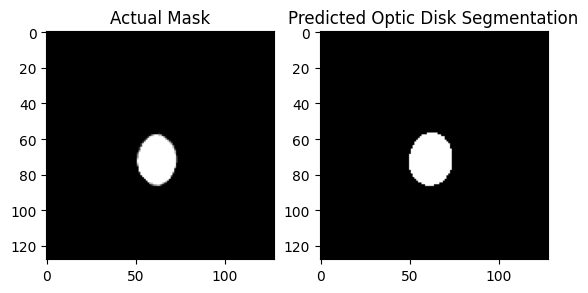

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


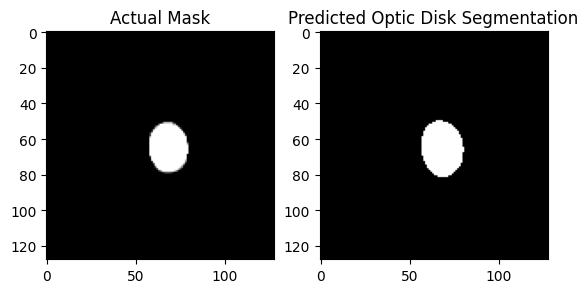

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


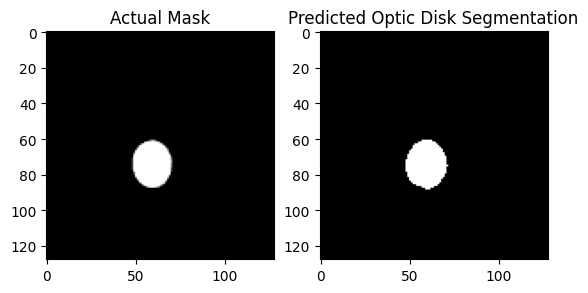

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


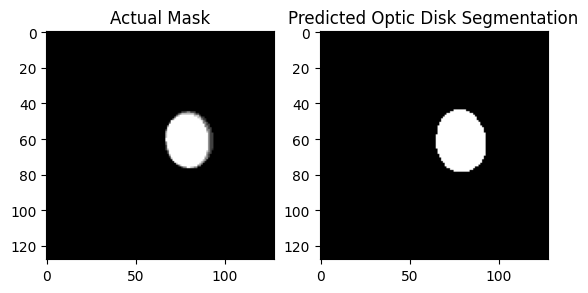

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


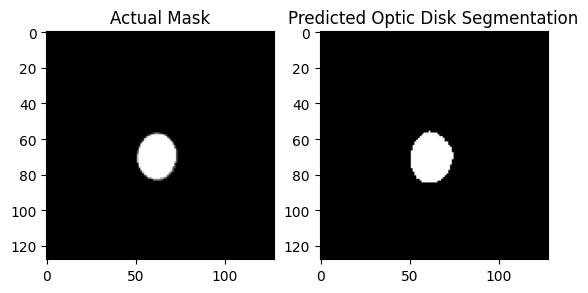

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


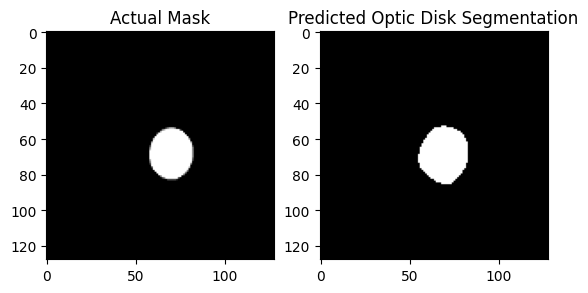

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


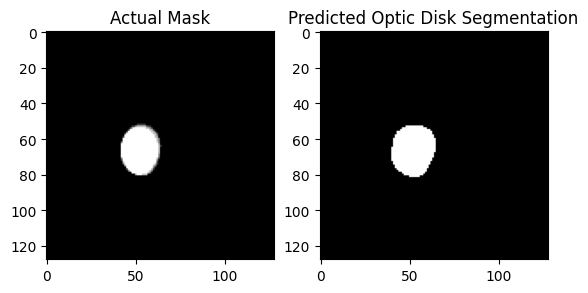

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


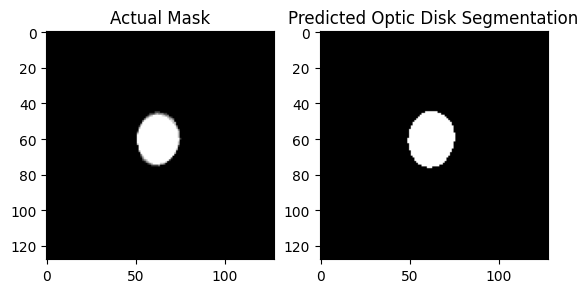

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


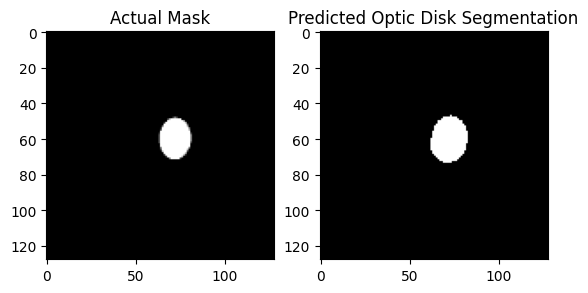

In [38]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predicted_mask(model, image):
    # Preprocess the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))  # Resize image to match the U-Net input size
    image = np.expand_dims(image, axis=0)  # Add an extra dimension for the batch size

    # Use the model to predict the mask
    predicted_mask = model.predict(image)[0, :, :, 0]

    # Binarize the predicted mask
    binarized_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Find contours in the binarized mask
    contours, _ = cv2.findContours(binarized_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour is the optic disk
    optic_disk_contour = max(contours, key=cv2.contourArea)

    # Draw the optic disk contour on a black mask
    disk_mask = np.zeros_like(binarized_mask)
    cv2.drawContours(disk_mask, [optic_disk_contour], -1, 1, thickness=cv2.FILLED)
    return disk_mask

def displaying_mask(predict, actual):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title('Actual Mask')
    plt.imshow(actual, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Predicted Optic Disk Segmentation')
    plt.imshow(predict, cmap='gray')

    plt.show()
    
# Example usage
test_images_folder = '/kaggle/input/glaucomaupdated/Drishti-GS1_files/Test/Images'
predicted_masks_folder = '/kaggle/working/predicted_masks_disk'  # Folder to save predicted masks

# Create the folder to save predicted masks if it doesn't exist
os.makedirs(predicted_masks_folder, exist_ok=True)

# Iterate over each image in the test dataset
for filename in os.listdir(test_images_folder):
    image_path = os.path.join(test_images_folder, filename)
    image = cv2.imread(image_path)
    
    # Predict the mask
    predicted_mask_disk = predicted_mask(model2, image)
    
    # Save the predicted mask
    mask_filename = os.path.splitext(filename)[0] + '_predicted_mask.png'
    mask_path = os.path.join(predicted_masks_folder, mask_filename)
    cv2.imwrite(mask_path, predicted_mask_disk * 255)

    # Optionally, display or perform further analysis on the predicted mask
    actual_mask_path2 = os.path.join('/kaggle/input/glaucomaupdated/Drishti-GS1_files/Test/optic_disk', os.path.splitext(filename)[0] + '_ODsegSoftmap.png')
    actual_mask2 = cv2.imread(actual_mask_path2, cv2.IMREAD_GRAYSCALE)
    actual_mask2 = cv2.resize(actual_mask2, (128, 128))  # Resize mask to match the U-Net input size
    displaying_mask(predicted_mask_disk, actual_mask2)


In [52]:
def round_down(n, decimals=0):
    multiplier = 10**decimals
    return math.floor(n * multiplier) / multiplier

In [80]:
import cv2
import numpy as np
import math
import os
import pandas as pd

def calculate_cdr(oc_image_path, od_image_path):
    # Load the images
    oc_image = cv2.imread(oc_image_path, cv2.IMREAD_GRAYSCALE)
    od_image = cv2.imread(od_image_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the images to get binary images
    _, oc_binary = cv2.threshold(oc_image, 127, 255, cv2.THRESH_BINARY)
    _, od_binary = cv2.threshold(od_image, 127, 255, cv2.THRESH_BINARY)

    # Calculate the areas
    oc_area = np.sum(oc_binary == 255)
    od_area = np.sum(od_binary == 255)

    # Calculate the cup to disk ratio
    cdr = oc_area / od_area
    cdr = math.floor(cdr * 10) / 10
    return cdr

def classify_eye(cdr):
    print(cdr)
    if cdr <= 0.5:
        return "Normal"
    else:
        return "Glaucoma"

# Paths to predicted masks folders
cup_folder = '/kaggle/working/predicted_masks_cup'
disk_folder = '/kaggle/working/predicted_masks_disk'

# Create a list to store results
results = []

# Iterate over files in the cup folder
for cup_filename in os.listdir(cup_folder):
    cup_path = os.path.join(cup_folder, cup_filename)
    # Corresponding filename in disk folder
    disk_filename = cup_filename.replace('_cup', '_disk')
    disk_path = os.path.join(disk_folder, disk_filename)
    
    # Calculate CDR and classify the eye
    cdr = calculate_cdr(cup_path, disk_path)
    classification = classify_eye(cdr)
    
    # Append to results list
    results.append({'Image': cup_filename, 'CDR': cdr, 'Classification': classification})

# Convert results to DataFrame
df = pd.DataFrame(results)

# Save results to Excel file
excel_filename = '/kaggle/working/glaucoma_detection_results.xlsx'
df.to_excel(excel_filename, index=False)

print("Results saved to:", excel_filename)

0.7
0.6
0.7
0.6
0.6
0.6
0.7
0.7
0.6
0.6
0.7
0.6
0.7
0.7
0.6
0.6
0.6
0.7
0.7
0.6
0.6
0.7
0.7
0.7
0.7
0.3
0.7
0.7
0.7
0.6
0.5
0.6
0.7
0.7
0.6
0.6
0.5
0.6
0.6
0.5
0.5
0.6
0.6
0.6
0.6
0.6
0.8
0.6
0.7
0.6
0.7
Results saved to: /kaggle/working/glaucoma_detection_results.xlsx


# **Model Evaluation for optic cup segmentation**

In [31]:
# Evaluate the model on the test dataset
scores = model.evaluate(valid_dataset)

# Print the test set performance (you can also display or save these values as needed)
print(f'Test Loss: {scores[0]}')
print(f'Test Accuracy: {scores[1]}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.9588 - loss: -183.1581
Test Loss: -201.4937744140625
Test Accuracy: 0.9589652419090271


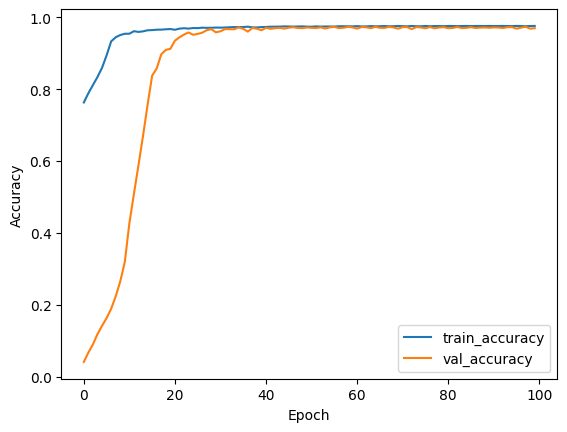

In [33]:
# Plot training and validation accuracy
plt.plot(history.history['acc'], label='train_accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

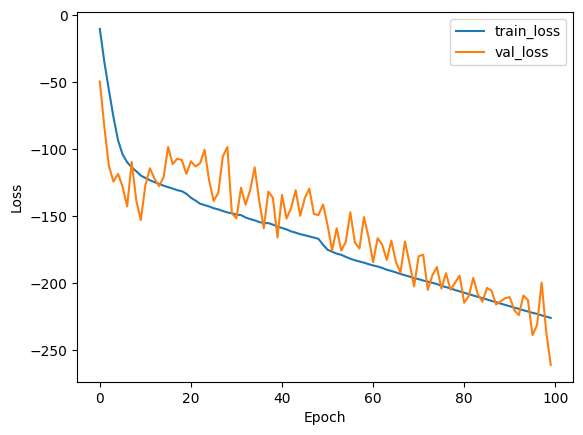

In [34]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ****Model Evaluation for optic disk segmentation****

In [38]:
# Evaluate the model on the test dataset
scores = model.evaluate(validation_dataset)

# Print the test set performance (you can also display or save these values as needed)
print(f'Test Loss: {scores[0]}')
print(f'Test Accuracy: {scores[1]}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.9586 - loss: -346.0717
Test Loss: -346.6148376464844
Test Accuracy: 0.9587019085884094


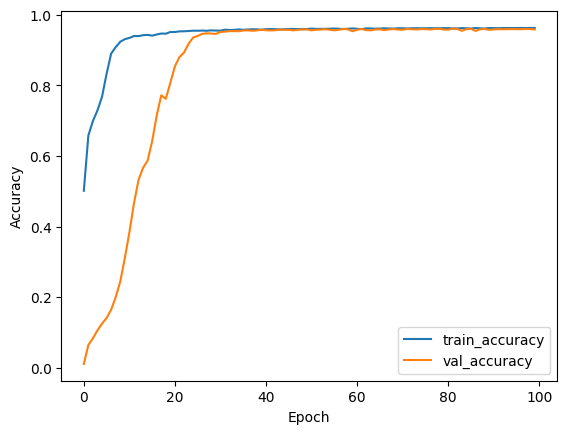

In [40]:
# Plot training and validation accuracy
plt.plot(history2.history['acc'], label='train_accuracy')
plt.plot(history2.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

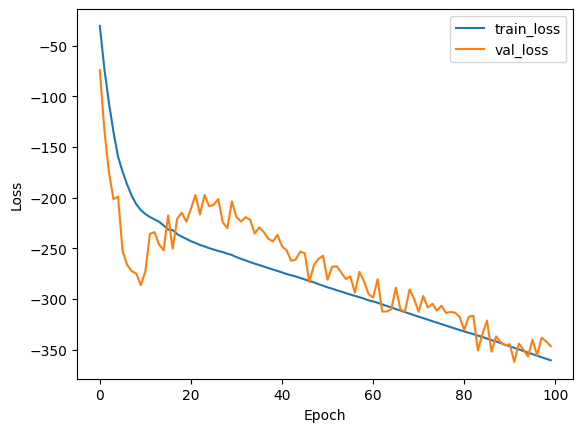

In [44]:
# Plot training and validation loss
plt.plot(history2.history['loss'], label='train_loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [66]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

# Assuming actual_mask and predicted_mask are your actual and predicted masks for a single image
# Flatten the masks and convert to binary
actual_mask = cv2.resize(actual_mask, (128, 128))
predicted_mask = cv2.resize(predicted_mask, (128, 128))
y_true = np.array(actual_mask).flatten()
y_pred = np.array(predicted_mask).flatten()

# Binarize the predictions
y_pred = (y_pred > 0.5).astype(np.uint8)

# Calculate precision and recall
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')



Precision: 0.96453857421875
Recall: 0.96453857421875


In [67]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

# Assuming actual_mask and predicted_mask are your actual and predicted masks for a single image
# Flatten the masks and convert to binary
actual_mask2 = cv2.resize(actual_mask2, (128, 128))
predicted_mask_disk = cv2.resize(predicted_mask_disk, (128, 128))
y_true = np.array(actual_mask2).flatten()
y_pred = np.array(predicted_mask_disk).flatten()

# Binarize the predictions
y_pred = (y_pred > 0.5).astype(np.uint8)

# Calculate precision and recall
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')



Precision: 0.96441650390625
Recall: 0.96441650390625


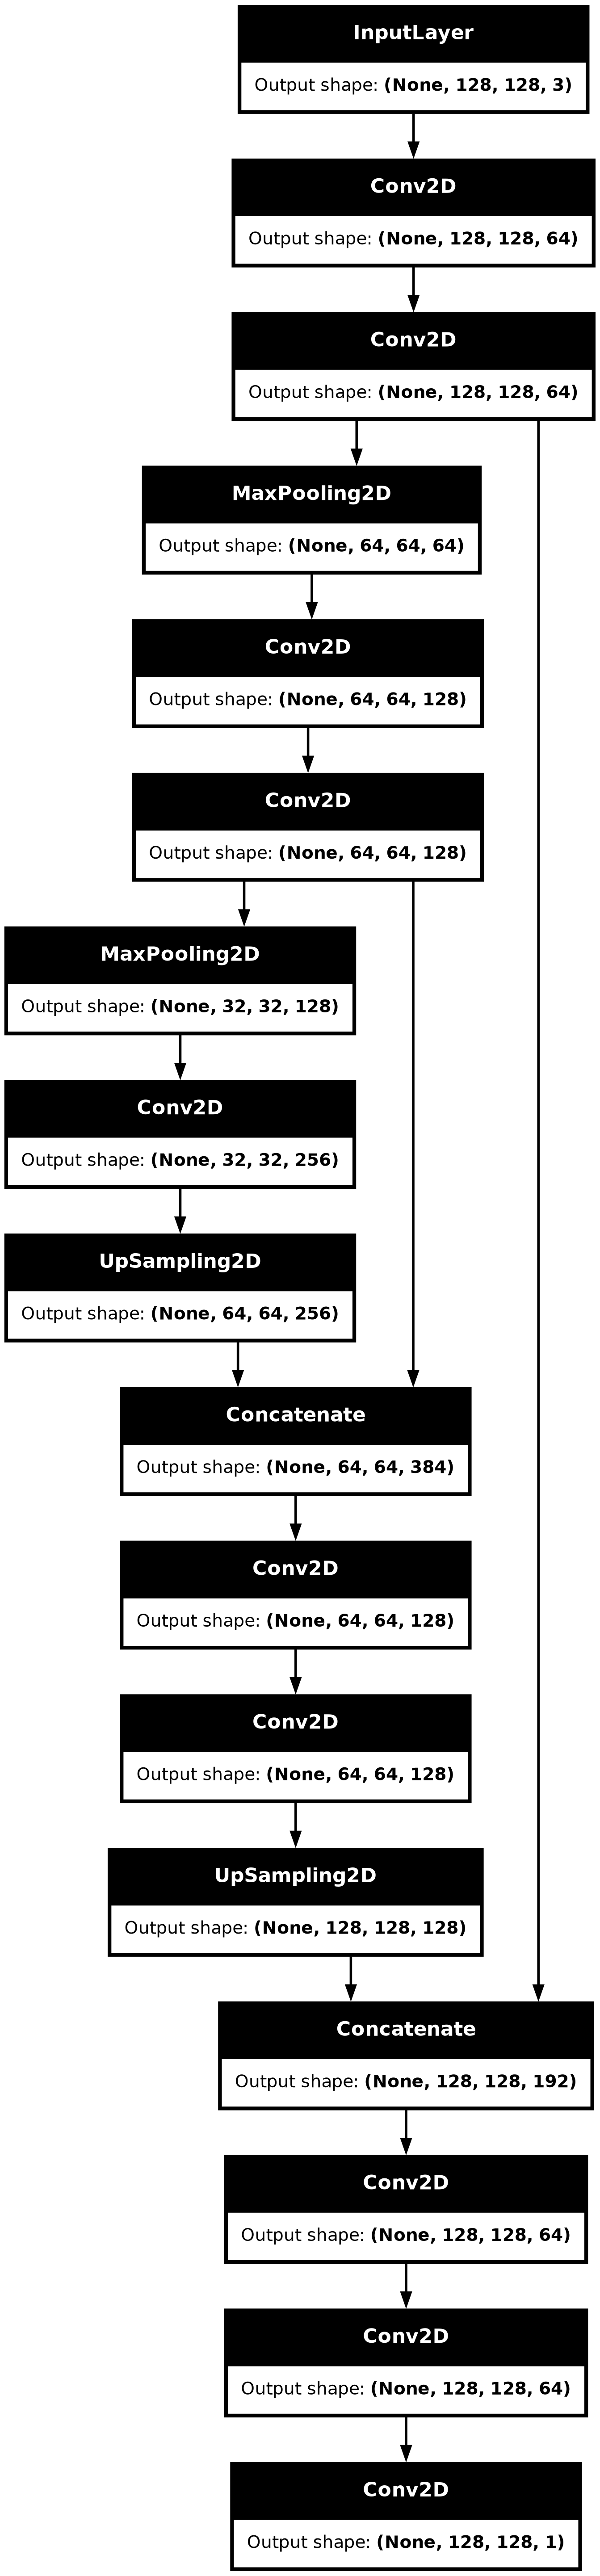

In [3]:
import pydot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def encoder_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same", activation="relu")(inputs)
    x = Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    return x, MaxPooling2D(pool_size=(2, 2))(x)

def decoder_block(inputs, skip, num_filters):
    x = UpSampling2D(size=(2, 2))(inputs)
    x = concatenate([skip, x], axis=3)
    x = Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    x = Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    b1 = Conv2D(256, 3, padding="same", activation="relu")(p2)
    d1 = decoder_block(b1, s2, 128)
    d2 = decoder_block(d1, s1, 64)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d2)
    model = Model(inputs, outputs, name="UNET")
    return model

# Define input shape
input_shape = (128, 128, 3)

# Build the UNet model
model = build_unet(input_shape)

# Plot the model architecture and save as an image
plot_model(model, to_file='/kaggle/working/unet_model.png', show_shapes=True)


In [8]:
from graphviz import Digraph

# Create Digraph object
flowchart = Digraph()

# Add nodes to the flowchart
flowchart.node('Start', 'Start', shape='ellipse')
flowchart.node('Load Data', 'Load Dataset', shape='parallelogram')
flowchart.node('Train Optic Cup Model', 'Train Optic Cup Model', shape='box')
flowchart.node('Train Optic Disk Model', 'Train Optic Disk Model', shape='box')
flowchart.node('Test Model', 'Test Model', shape='box')
flowchart.node('Predict Masks', 'Predict Masks', shape='parallelogram')
flowchart.node('Calculate CDR', 'Calculate CDR', shape='parallelogram')
flowchart.node('Glaucoma Detection', 'Glaucoma Detection', shape='parallelogram')
flowchart.node('Calculate Accuracy', 'Calculate Accuracy', shape='parallelogram')

# Define edges between nodes
edges = [
    ('Start', 'Load Data'),
    ('Load Data', 'Train Optic Cup Model'),
    ('Load Data', 'Train Optic Disk Model'),
    ('Train Optic Cup Model', 'Test Model'),
    ('Train Optic Disk Model', 'Test Model'),
    ('Test Model', 'Predict Masks'),
    ('Predict Masks', 'Calculate CDR'),
    ('Calculate CDR', 'Glaucoma Detection'),
    ('Glaucoma Detection', 'Calculate Accuracy')
]

# Add edges to the flowchart
for edge in edges:
    flowchart.edge(*edge)

# Render the flowchart
flowchart.render('/kaggle/working/flowchart', format='png', cleanup=True)

print("Flowchart saved as 'flowchart.png' in the working directory.")


Flowchart saved as 'flowchart.png' in the working directory.


In [10]:
from graphviz import Digraph

# Create Digraph object
flowchart = Digraph()

# Add nodes to the flowchart with different fill colors
flowchart.node('Start', 'Start', shape='ellipse', style='filled', fillcolor='lightblue')
flowchart.node('Load Data', 'Load Dataset', shape='parallelogram', style='filled', fillcolor='lightgreen')
flowchart.node('Train Optic Cup Model', 'Train Optic Cup Model', shape='box', style='filled', fillcolor='lightcoral')
flowchart.node('Train Optic Disk Model', 'Train Optic Disk Model', shape='box', style='filled', fillcolor='lightsalmon')
flowchart.node('Test Model', 'Test Model', shape='box', style='filled', fillcolor='lightgoldenrodyellow')
flowchart.node('Predict Masks', 'Predict Masks', shape='parallelogram', style='filled', fillcolor='lightgrey')
flowchart.node('Calculate CDR', 'Calculate CDR', shape='parallelogram', style='filled', fillcolor='lightpink')
flowchart.node('Glaucoma Detection', 'Glaucoma Detection', shape='parallelogram', style='filled', fillcolor='lightseagreen')
flowchart.node('Calculate Accuracy', 'Calculate Accuracy', shape='parallelogram', style='filled', fillcolor='lightsteelblue')

# Define edges between nodes
edges = [
    ('Start', 'Load Data'),
    ('Load Data', 'Train Optic Cup Model'),
    ('Load Data', 'Train Optic Disk Model'),
    ('Train Optic Cup Model', 'Test Model'),
    ('Train Optic Disk Model', 'Test Model'),
    ('Test Model', 'Predict Masks'),
    ('Predict Masks', 'Calculate CDR'),
    ('Calculate CDR', 'Glaucoma Detection'),
    ('Glaucoma Detection', 'Calculate Accuracy')
]

# Add edges to the flowchart
for edge in edges:
    flowchart.edge(*edge)

# Render the flowchart
flowchart.render('/kaggle/working/flowchart', format='png', cleanup=True)

print("Flowchart saved as 'flowchart.png' in the working directory.")


Flowchart saved as 'flowchart.png' in the working directory.
